In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.integrate import cumtrapz
from scipy.signal import savgol_filter
import sys, os, pickle, string
from autophasemap import plot_clusters
color_blindf = ["#3f90da", "#ffa90e", "#bd1f01", "#832db6", 
"#a96b59", "#e76300", "#b9ac70", "#92dadd", "#94a4a2"]
bkg_spectra_color = "#717581"
SAVE_DIR = "../../figures/blends/"

In [10]:
pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight'
              } 

In [11]:
with open('./data_smooth4.pkl', 'rb') as f:
    result = pickle.load(f)
    
n_clusters = 4


In [12]:
class DataSet:
    def __init__(self, C, q, Iq, N, n_domain=200):
        self.n_domain = n_domain
        self.t = np.linspace(0,1, num=self.n_domain)
        self.N = N
        self.Iq = Iq
        self.C = C
        self.q = q
        
    def generate(self, process=None):
        if process=="normalize":
            self.F = [self.Iq[i]/self.l2norm(self.Iq[i]) for i in range(self.N)]
        elif process=="smoothen":
            self.F = [self._smoothen(self.Iq[i,:]/self.l2norm(self.Iq[i])) for i in range(self.N)]
        elif process is None:
            self.F = [self.Iq[i] for i in range(self.N)]
            
        return
        
    def l2norm(self, f):
        norm = np.sqrt(np.trapz(f**2, data.t))
        
        return norm
    
    def _smoothen(self, f):
        f_hat = savgol_filter(f, 8, 3)
        
        return f_hat

saxs = np.load('../../expts/OMIECS/blends_WSCP_P123_NOpH.npz')

q = saxs['q']
n_domain = len(saxs['q'])

swap_c_columns = np.zeros_like(saxs['C'])
swap_c_columns[:,0] = saxs['C'][:,1] 
swap_c_columns[:,1] = saxs['C'][:,0] 
C = swap_c_columns
Iq = saxs['Iq']

N = C.shape[0]

data = DataSet(C, q, Iq, N, n_domain=n_domain)
data.generate(process="smoothen")
print('Number of functions : ', data.N)
print('Domain sampling of each function : ', n_domain)
print('Design space shape : ', data.C.shape)

Number of functions :  93
Domain sampling of each function :  1304
Design space shape :  (93, 2)


## Visualization for the paper

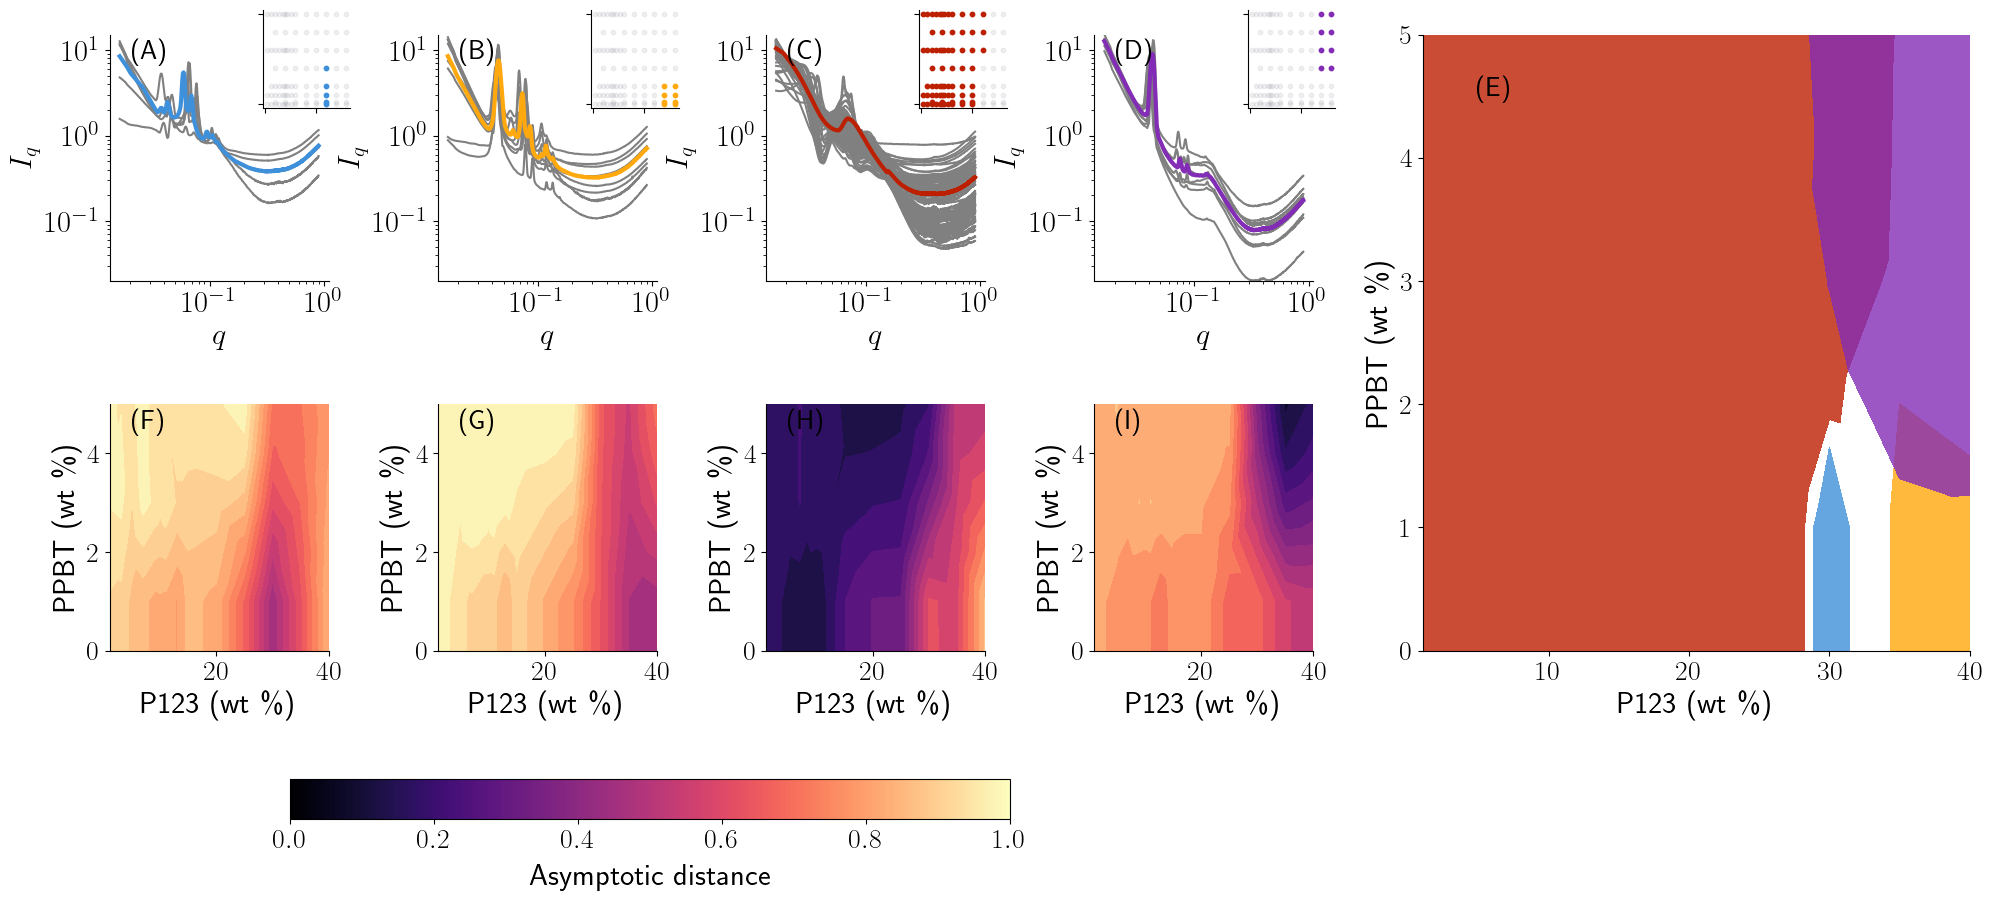

In [13]:
def setup_axs():
    layout = [['A1','A2', 'A3', 'A4', 'C', 'C'], 
              ['B1', 'B2', 'B3', 'B4', 'C', 'C']
              ]
    fig, axs = plt.subplot_mosaic(layout, figsize=(4*6, 4*2))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    for k, (_,ax) in enumerate(axs.items()):
        ax.text(0.1, 0.9, r'(%s)'%string.ascii_uppercase[k], 
        transform=ax.transAxes, 
        size=20, weight='bold'
        )
    return fig, axs

cmap = cm.get_cmap('magma')
norm = Normalize(vmin=0, vmax = 1)
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)


def plot_contours_distance(axs, data, result):
    for k, ax in enumerate(axs):
        dist = result['dist'][:,k]
        ax.tricontourf(data.C[:,0], 
                       data.C[:,1], 
                       dist,
                       15,
                       cmap=cmap,
                       norm = norm
                      )

        ax.set_xlabel('P123 (wt \%)', fontsize=22)
        ax.set_ylabel('PPBT (wt \%)', fontsize=22)
        ax.tick_params(labelsize=20)

    return 

with plt.style.context(pyplot_style):
    fig, axs = setup_axs()
    ax_clusters = [axs[k] for k in ['A1', 'A2', 'A3', 'A4']]
    plot_clusters(ax_clusters,data, result, mode="input")

    ax_contours = [axs[k] for k in ['B1', 'B2', 'B3', 'B4']]
    plot_contours_distance(ax_contours,data, result)

    norm = Normalize(vmin=0, vmax=1)
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    cax = fig.add_axes([0.2, -0.1, 0.3, 0.05])        
    cbar = fig.colorbar(mappable, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=20) 
    cbar.ax.set_xlabel('Asymptotic distance',
                    labelpad=8,
                    fontsize=22,
                    rotation='horizontal'
                    )

    ax_map = axs['C']
    for k in range(n_clusters):
        dist = result['dist'][:,k]
        ax_map.tricontourf(data.C[:,0], 
                    data.C[:,1],
                    dist,
                    levels=[0.0, 0.5],
                    colors=color_blindf[k],
                    alpha=0.8
                    )

    ax_map.set_xlabel('P123 (wt \%)', fontsize=22)
    ax_map.set_ylabel('PPBT (wt \%)', fontsize=22)
    ax_map.tick_params(labelsize=20)
    plt.savefig(SAVE_DIR+'full_template4.pdf')
    plt.show()